# Real-time path-tracing denoising

Vincent Higginson

In [1]:
!pip install scikit-image matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
import os
import struct
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def load_image(path):
    buffer = open(path, "rb")
    data = buffer.read()
    num_floats = len(data) // 16
    pixels = np.array(struct.unpack('f'*num_floats*4, data), dtype=np.float32)
    pixels = np.flipud(np.reshape(pixels, (720, 1280, 4)))
    img = cv2.cvtColor(pixels, cv2.COLOR_RGBA2RGB)

    buffer.close()

    return img

def display_image(img, label=""):
    plt.figure(figsize = (20, 20))
    plt.imshow(img, interpolation='nearest')
    plt.title(label)
    plt.show()

## Ground truth images

Loaded from a 1024spp renderings.No denoising applied, just an accumulation of the results of 1024 frames.

Disposition of the camera for the Sponza scene:

```cpp
camera.angle = 0.0f;
camera.speed = 0.0f;
camera.distance = 1.0f;
camera.center = glm::vec3(0.0f, 1.0f, 0.0f);
```

Disposition of the camera for the DeleteMe scene:

```cpp
camera.angle = 45.0f;
camera.speed = 0.0f;
camera.distance = 10.0f;
camera.center = glm::vec3(0.0f, 1.0f, 0.0f);
```

Disposition of the camera for the Dragon scene:

```cpp
camera.angle = 25.0f;
camera.speed = 0.0f;
camera.distance = 24.0f;
camera.center = glm::vec3(0.0f, 3.5f, 0.0f);
```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


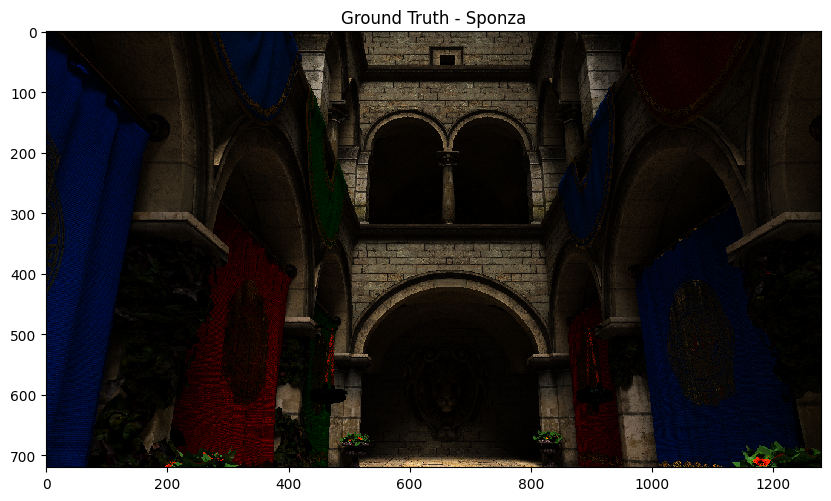

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


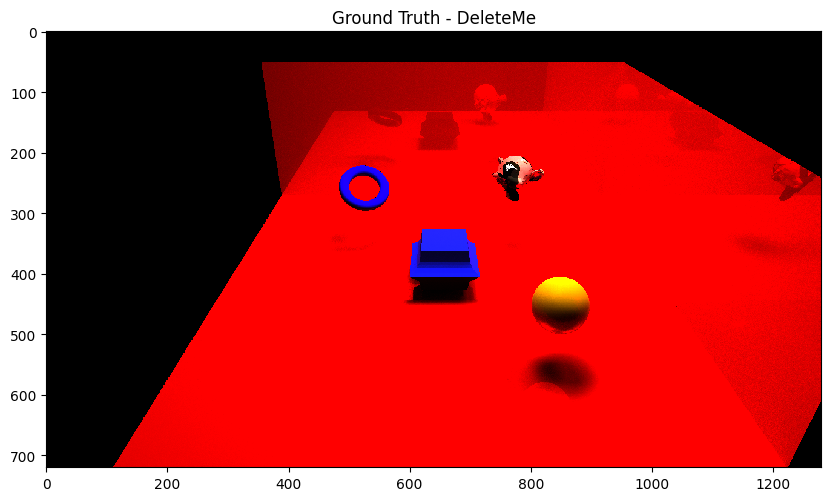

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


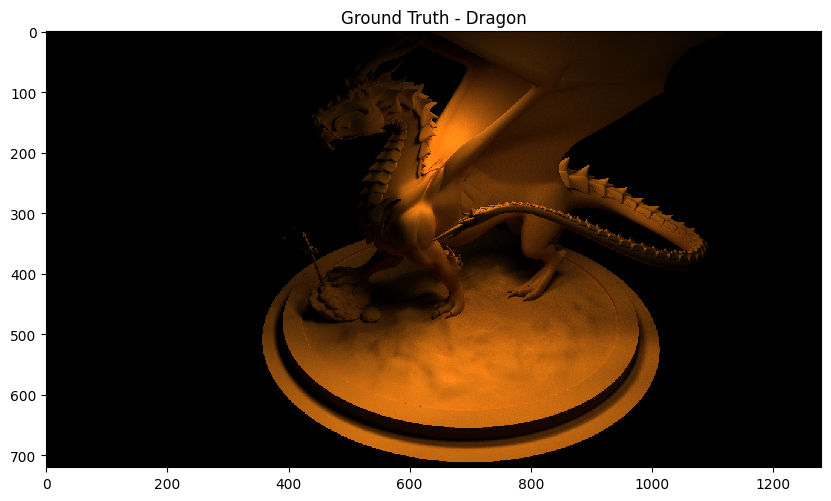

In [4]:
sponza_ground_truth = load_image("blobs/sponza_blob_1024_accum.buff")

plt.figure(figsize = (10, 10))
plt.imshow(sponza_ground_truth, interpolation='nearest')
plt.title('Ground Truth - Sponza')
plt.show()

deleteme_ground_truth = load_image("blobs/deleteme_blob_1024_accum.buff")

plt.figure(figsize = (10, 10))
plt.imshow(deleteme_ground_truth, interpolation='nearest')
plt.title('Ground Truth - DeleteMe')
plt.show()

dragon_ground_truth = load_image("blobs/dragon_blob_1024_accum.buff")

plt.figure(figsize = (10, 10))
plt.imshow(dragon_ground_truth, interpolation='nearest')
plt.title('Ground Truth - Dragon')
plt.show()

## BMFR images

Different denoising configurations for the sponza scene. All denoised with BMFR. The 15th frame is used to make the comparison with the ground truth.

SSIM (structural similarity) and MSE (mean-squared error) are computed and plotted for each configurations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


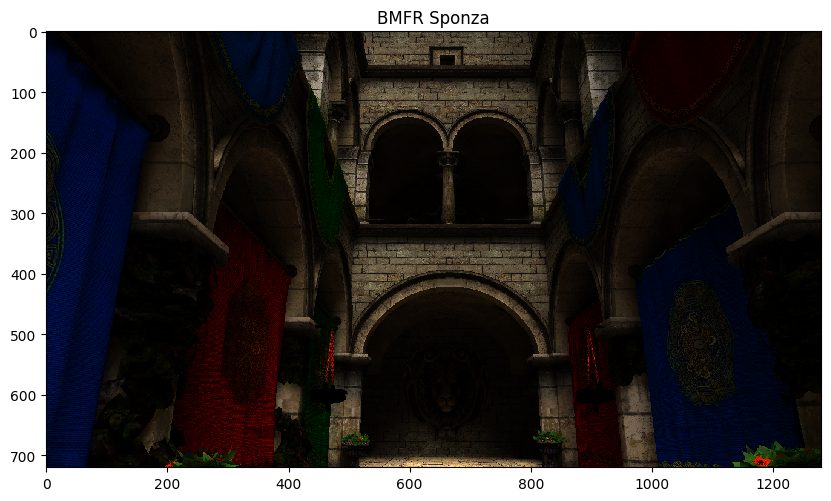

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


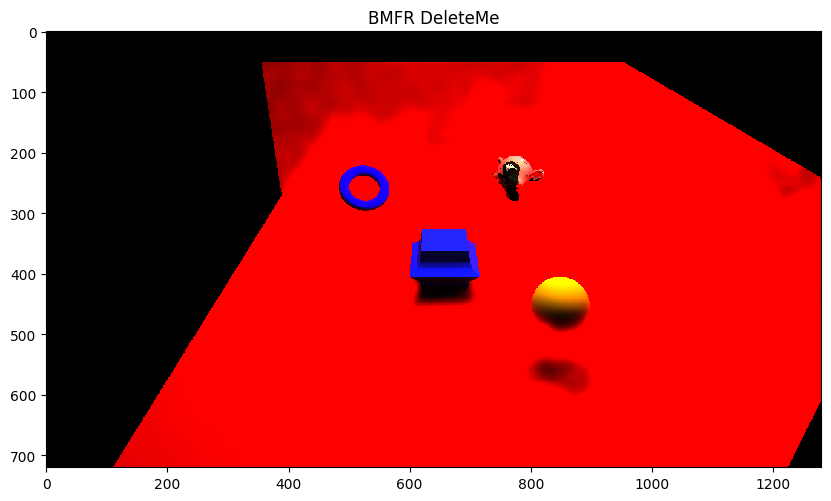

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


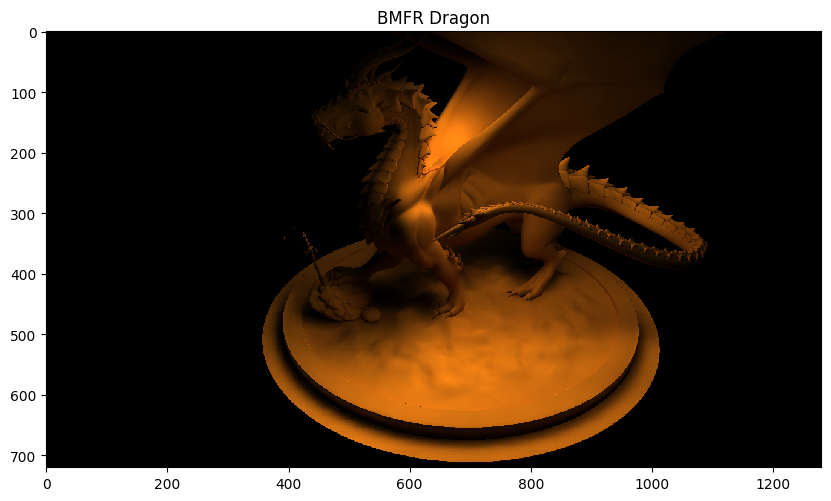

In [5]:
sponza_bmfr = load_image("blobs/sponza_blob_15_bmfr.buff")
deleteme_bmfr = load_image("blobs/deleteme_blob_15_bmfr.buff")
dragon_bmfr = load_image("blobs/dragon_blob_15_bmfr.buff")

plt.figure(figsize = (10, 10))
plt.imshow(sponza_bmfr, interpolation='nearest')
plt.title('BMFR Sponza')
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(deleteme_bmfr, interpolation='nearest')
plt.title('BMFR DeleteMe')
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(dragon_bmfr, interpolation='nearest')
plt.title('BMFR Dragon')
plt.show()

In [6]:
score_sponza_ssim_bmfr = ssim(sponza_ground_truth, sponza_bmfr, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_sponza_mse_bmfr = mse(sponza_ground_truth, sponza_bmfr)

score_deleteme_ssim_bmfr = ssim(deleteme_ground_truth, deleteme_bmfr, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_deleteme_mse_bmfr = mse(deleteme_ground_truth, deleteme_bmfr)

score_dragon_ssim_bmfr = ssim(dragon_ground_truth, dragon_bmfr, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_dragon_mse_bmfr = mse(dragon_ground_truth, dragon_bmfr)

print("SSIM sponza:", score_sponza_ssim_bmfr)
print("MSE sponza:", score_sponza_mse_bmfr)

print("SSIM deleteme:", score_deleteme_ssim_bmfr)
print("MSE deleteme:", score_deleteme_mse_bmfr)

print("SSIM dragon:", score_dragon_ssim_bmfr)
print("MSE dragon:", score_dragon_mse_bmfr)

SSIM sponza: 0.9637825
MSE sponza: 0.00032154078209118813
SSIM deleteme: 0.92503935
MSE deleteme: 0.046900623345225954
SSIM dragon: 0.9803887
MSE dragon: 0.00019234583861317463


[16, 25, 36, 49]
[33.51832320733928, 34.16358554793056, 34.37771963227757, 34.52470766647067]
[0.9528697, 0.9587807, 0.9616224, 0.9636419]


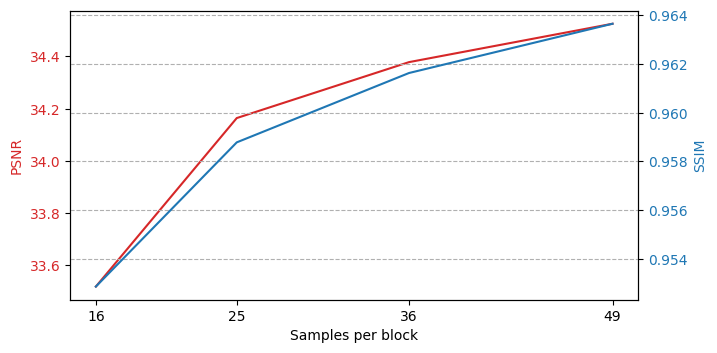

In [7]:
# sample_per_block = [i*i for i in range(4, 11)]
sample_per_block = [16, 25, 36, 49]
print(sample_per_block)

ground_truth_pose1 = load_image("blobs/screenshot_blob_1024_accum_pos1.buff")

# display_image(ground_truth_pose1)

results_psnr = []
results_ssim = []

for s in sample_per_block:
    img = load_image("blobs/screenshot_blob_30_bmfr_%d_sample.buff" % s)
    # display_image(img)
    p_s = psnr(ground_truth_pose1, img, data_range=ground_truth_pose1.max()-ground_truth_pose1.min())
    s_s = ssim(ground_truth_pose1, img, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
    results_psnr.append(p_s)
    results_ssim.append(s_s)

print(results_psnr)
print(results_ssim)

fig, ax1 = plt.subplots()
fig.set_size_inches(20/2.75, 10/2.75)

color = 'tab:red'
ax1.set_xlabel('Samples per block')
ax1.set_xticks(sample_per_block)
ax1.set_ylabel('PSNR', color=color)
ax1.plot(sample_per_block, results_psnr, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SSIM', color=color)  # we already handled the x-label with ax1
ax2.plot(sample_per_block, results_ssim, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(which='both', axis='both', linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
plt.show()

[16, 25, 36, 49]
[21.60311521464015, 22.820966229260627, 31.761095650367032, 34.37852095997445]
[0.84913987, 0.8811229, 0.9559528, 0.9615667]


/tmp/ipykernel_54634/4182807483.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(config)


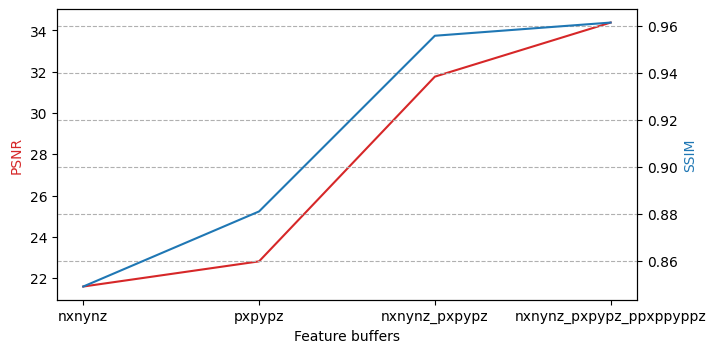

In [8]:
# sample_per_block = [i*i for i in range(4, 11)]
config = ["nxnynz", "pxpypz", "nxnynz_pxpypz", "nxnynz_pxpypz_ppxppyppz"]#, "nxny"]
print(sample_per_block)

ground_truth_pose1 = load_image("blobs/screenshot_blob_1024_accum_pos1.buff")

# display_image(ground_truth_pose1)

results_psnr = []
results_ssim = []

for s in config:
    img = load_image("blobs/screenshot_blob_30_bmfr_%s.buff" % s)
    
    # display_image(img)
    p_s = psnr(ground_truth_pose1, img, data_range=ground_truth_pose1.max()-ground_truth_pose1.min())
    s_s = ssim(ground_truth_pose1, img, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
    results_psnr.append(p_s)
    results_ssim.append(s_s)

print(results_psnr)
print(results_ssim)

fig, ax1 = plt.subplots()
fig.set_size_inches(20/2.75, 10/2.75)

color = 'tab:red'
ax1.set_xlabel('Feature buffers')
ax1.set_xticklabels(config)
ax1.set_ylabel('PSNR', color=color)
ax1.plot(config, results_psnr, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SSIM', color=color)  # we already handled the x-label with ax1
ax2.plot(config, results_ssim, color=color)
# ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(which='both', axis='both', linestyle='--')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

[16, 25, 36, 49]
[15.107988254173101, 23.36317590839848, 23.22265234727203, 34.85294734566273, 24.433948003465517]
[0.6247122, 0.8740129, 0.8800509, 0.9627381, 0.89345497]


/tmp/ipykernel_54634/73285280.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(config)


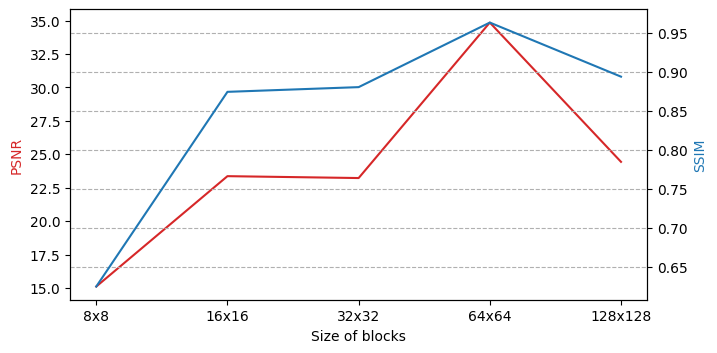

In [9]:
# sample_per_block = [i*i for i in range(4, 11)]
config = ["8x8", "16x16", "32x32", "64x64", "128x128"]
print(sample_per_block)

ground_truth_pose1 = load_image("blobs/screenshot_blob_1024_accum_pos1.buff")

# display_image(ground_truth_pose1)

results_psnr = []
results_ssim = []

for s in config:
    img = load_image("blobs/screenshot_blob_30_bmfr_%s.buff" % s)
    
    # display_image(img)
    p_s = psnr(ground_truth_pose1, img, data_range=ground_truth_pose1.max()-ground_truth_pose1.min())
    s_s = ssim(ground_truth_pose1, img, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
    results_psnr.append(p_s)
    results_ssim.append(s_s)

print(results_psnr)
print(results_ssim)

fig, ax1 = plt.subplots()
fig.set_size_inches(20/2.75, 10/2.75)

color = 'tab:red'
ax1.set_xlabel('Size of blocks')
ax1.set_xticklabels(config)
ax1.set_ylabel('PSNR', color=color)
ax1.plot(config, results_psnr, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('SSIM', color=color)  # we already handled the x-label with ax1
ax2.plot(config, results_ssim, color=color)
# ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(which='both', axis='both', linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## A-SVGF image - Sponza

Different denoising configurations for the sponza scene. All denoised with A-SVGF. The 15th frame is used to make the comparison with the ground truth.

SSIM (structural similarity) and MSE (mean-squared error) are computed and plotted for each configurations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


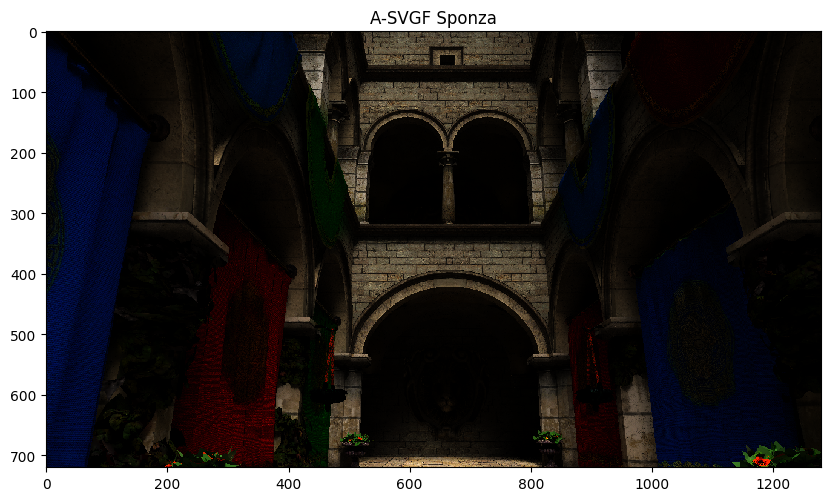

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


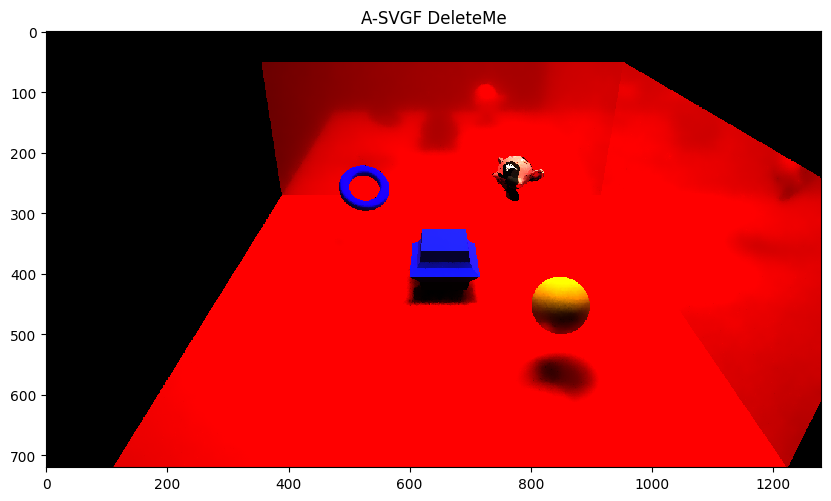

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


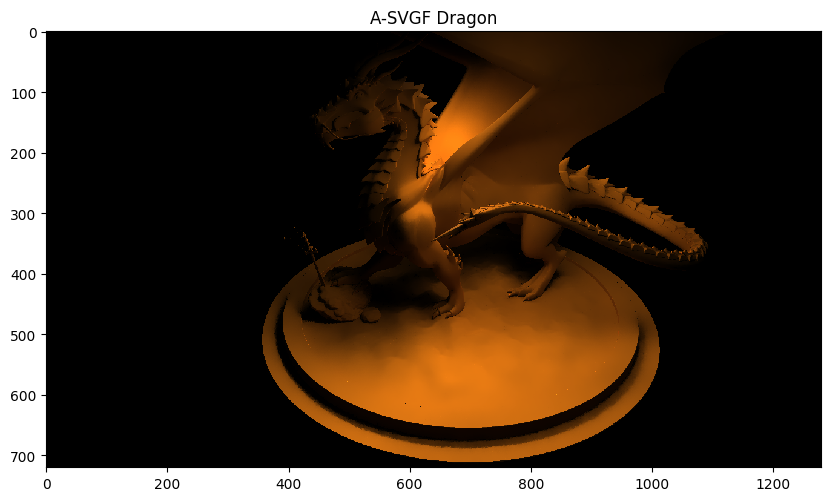

In [10]:
sponza_asvgf = load_image("blobs/sponza_blob_15_a-svgf.buff")
deleteme_asvgf = load_image("blobs/deleteme_blob_15_a-svgf.buff")
dragon_asvgf = load_image("blobs/dragon_blob_15_a-svgf.buff")

plt.figure(figsize = (10, 10))
plt.imshow(sponza_asvgf, interpolation='nearest')
plt.title('A-SVGF Sponza')
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(deleteme_asvgf, interpolation='nearest')
plt.title('A-SVGF DeleteMe')
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(dragon_asvgf, interpolation='nearest')
plt.title('A-SVGF Dragon')
plt.show()

In [5]:
score_sponza_ssim_asvgf = ssim(sponza_ground_truth, sponza_asvgf, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_sponza_mse_asvgf = mse(sponza_ground_truth, sponza_asvgf)
score_deleteme_ssim_asvgf = ssim(deleteme_ground_truth, deleteme_asvgf, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_deleteme_mse_asvgf = mse(deleteme_ground_truth, deleteme_asvgf)
score_dragon_ssim_asvgf = ssim(dragon_ground_truth, dragon_asvgf, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_dragon_mse_asvgf = mse(dragon_ground_truth, dragon_asvgf)

print("SSIM sponza:", score_sponza_ssim_asvgf)
print("MSE sponza:", score_sponza_mse_asvgf)

print("SSIM deleteme:", score_deleteme_ssim_asvgf)
print("MSE deleteme:", score_deleteme_mse_asvgf)

print("SSIM dragon:", score_dragon_ssim_asvgf)
print("MSE dragon:", score_dragon_mse_asvgf)

NameError: name 'sponza_ground_truth' is not defined

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

ssims_asvgf = []
ssims_bmfr = []

asvgf_video = []
bmfr_video = []

for i in range(0, 45):
    denoised_asvgf = load_image("/run/media/vincent/YeahMaBoyYeah/movies/a-svgf/sponza/denoised_blob_%d.buff" % i)
    denoised_bmfr = load_image("/run/media/vincent/YeahMaBoyYeah/movies/bmfr/sponza/denoised_blob_%d.buff" % i)
    truth = load_image("/run/media/vincent/YeahMaBoyYeah/movies/truth/sponza/truth_%d.buff" % (i+2))
    ssims_asvgf.append(ssim(truth, denoised_asvgf,  multichannel=True, channel_axis=2, data_range=truth.max()-truth.min()))
    ssims_bmfr.append(ssim(truth, denoised_bmfr,  multichannel=True, channel_axis=2, data_range=truth.max()-truth.min()))

    asvgf_video.append(np.clip(denoised_asvgf, 0.0, 1.0))
    bmfr_video.append(np.clip(denoised_bmfr, 0.0, 1.0))
    
    del truth

In [53]:
asvgf_video = np.array(asvgf_video)
print(asvgf_video)

fig = plt.figure(figsize=(16, 9), dpi=1920/16)
im = plt.imshow(asvgf_video[0,:,:,:])

manager = plt.get_current_fig_manager()
manager.full_screen_toggle()

plt.close()

def init():
    im.set_data(asvgf_video[0,:,:,:])

def animate(i):
    im.set_data(asvgf_video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=asvgf_video.shape[0],
                               interval=32)
HTML(anim.to_html5_video())

[[[[0.00000000e+00 3.75008211e-03 1.64586548e-02]
   [0.00000000e+00 3.16958176e-03 1.53201222e-02]
   [0.00000000e+00 1.41821138e-03 8.63313861e-03]
   ...
   [2.24374309e-02 1.59852114e-02 6.39459398e-03]
   [1.36437090e-02 9.47317667e-03 3.60454665e-03]
   [1.05031962e-02 7.04562664e-03 3.41657503e-03]]

  [[0.00000000e+00 4.62120492e-03 2.42655762e-02]
   [0.00000000e+00 6.99550612e-03 3.32572497e-02]
   [0.00000000e+00 2.88055278e-03 1.52529087e-02]
   ...
   [1.69835072e-02 1.13720940e-02 5.03977528e-03]
   [8.91824439e-03 5.95537759e-03 2.21661967e-03]
   [4.77250433e-03 3.03603220e-03 8.73987970e-04]]

  [[0.00000000e+00 4.16410109e-03 2.07953323e-02]
   [0.00000000e+00 4.99262474e-03 2.83747967e-02]
   [0.00000000e+00 5.95993921e-03 2.45519541e-02]
   ...
   [2.94516981e-02 1.99537855e-02 8.29332136e-03]
   [1.73713118e-02 1.17088994e-02 4.49737441e-03]
   [1.14939464e-02 7.39467610e-03 2.46459548e-03]]

  ...

  [[1.49011794e-05 1.40812695e-02 6.89895749e-02]
   [2.88394986e-

In [66]:
print(ssims_asvgf)
print(ssims_bmfr)

[0.79261655, 0.7487998, 0.76989335, 0.6590914, 0.91611457, 0.92679006, 0.93099266, 0.9317128, 0.9448743, 0.93937254, 0.94067454, 0.94011086, 0.9460706, 0.941053, 0.94818497, 0.9449733, 0.9455207, 0.9463861, 0.94515437, 0.9442671, 0.94631654, 0.94469357, 0.9514864, 0.94439346, 0.94477624, 0.9440894, 0.9436676, 0.94452876, 0.9446071, 0.9437518, 0.94512844, 0.9453266, 0.94763845, 0.9444959, 0.9428225, 0.9440193, 0.94548315, 0.94497365, 0.9448991, 0.9471734, 0.9467159, 0.94394857, 0.9465366, 0.94559556, 0.94821787]
[0.78459936, 0.7716139, 0.78939867, 0.673752, 0.9487985, 0.95372623, 0.95372504, 0.95221025, 0.95989895, 0.95309377, 0.95300275, 0.9516387, 0.9557045, 0.9503514, 0.9565797, 0.95335716, 0.95337135, 0.9541209, 0.95291615, 0.9521765, 0.9542277, 0.95262665, 0.9589152, 0.95251983, 0.952902, 0.9521344, 0.9519189, 0.95295143, 0.95294046, 0.95201784, 0.95340014, 0.95348597, 0.95534015, 0.9524484, 0.9507428, 0.9519572, 0.95331115, 0.95274466, 0.9524696, 0.95440716, 0.9539092, 0.9510107, 

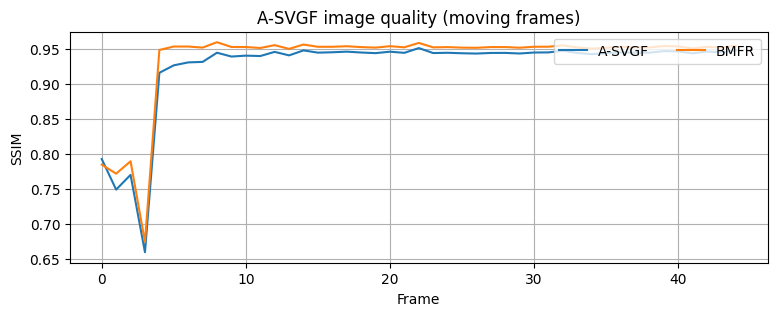

In [67]:
plt.figure(figsize = (9, 3))
plt.plot(ssims_asvgf, label="A-SVGF")
plt.plot(ssims_bmfr, label="BMFR")
plt.title('A-SVGF image quality (moving frames)')
plt.legend(loc='upper right', ncols=3)
plt.grid(True)
plt.ylabel("SSIM")
plt.xlabel("Frame")
plt.show()

## OIDN image - Sponza

Different denoising configurations for the sponza scene. All denoised with OIDN. The 15th frame is used to make the comparison with the ground truth.

SSIM (structural similarity) and MSE (mean-squared error) are computed and plotted for each configurations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


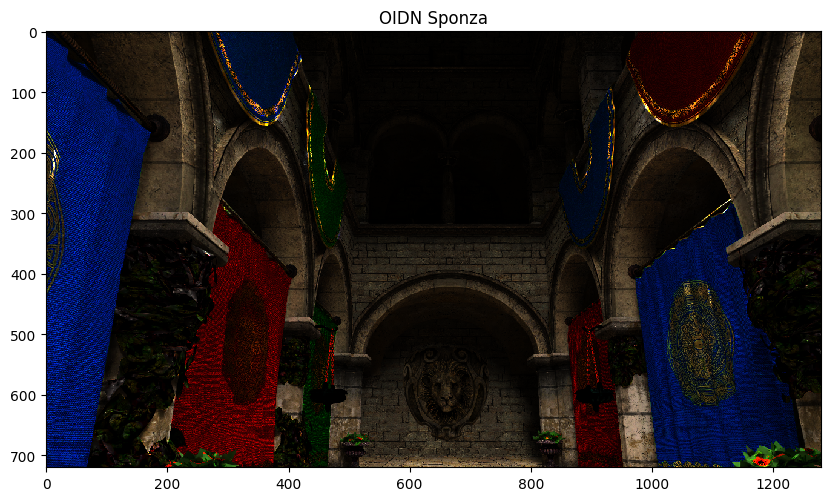

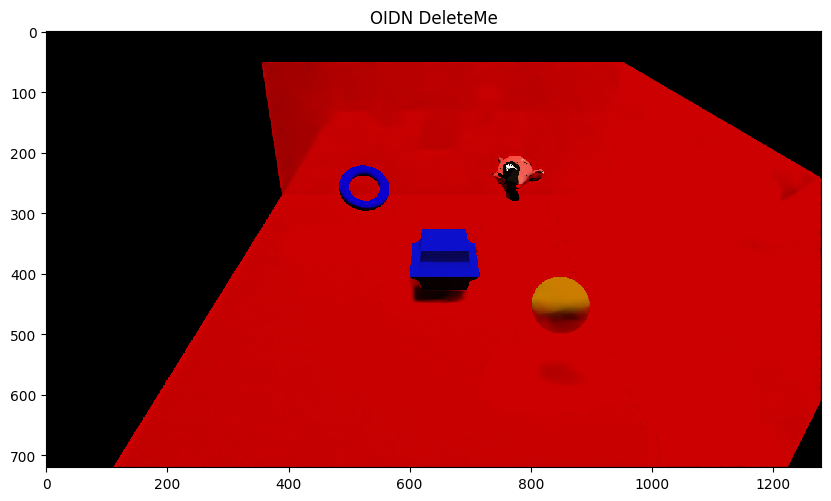

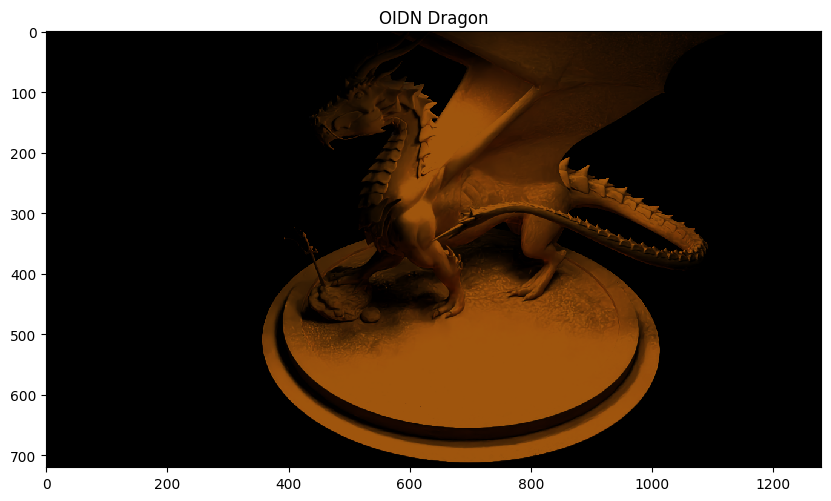

In [12]:
sponza_oidn = load_image("blobs/sponza_blob_15_oidn.buff")
deleteme_oidn = load_image("blobs/deleteme_blob_15_oidn.buff")
dragon_oidn = load_image("blobs/dragon_blob_15_oidn.buff")

plt.figure(figsize = (10, 10))
plt.imshow(sponza_oidn, interpolation='nearest')
plt.title('OIDN Sponza')
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(deleteme_oidn, interpolation='nearest')
plt.title('OIDN DeleteMe')
plt.show()

plt.figure(figsize = (10, 10))
plt.imshow(dragon_oidn, interpolation='nearest')
plt.title('OIDN Dragon')
plt.show()

In [13]:
score_sponza_ssim_oidn = ssim(sponza_ground_truth, sponza_oidn, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_sponza_mse_oidn = mse(sponza_ground_truth, sponza_oidn)
score_deleteme_ssim_oidn = ssim(deleteme_ground_truth, deleteme_oidn, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_deleteme_mse_oidn = mse(deleteme_ground_truth, deleteme_oidn)
score_dragon_ssim_oidn = ssim(dragon_ground_truth, dragon_oidn, multichannel=True, channel_axis=2, data_range=sponza_ground_truth.max()-sponza_ground_truth.min())
score_dragon_mse_oidn = mse(dragon_ground_truth, dragon_oidn)

print("SSIM sponza:", score_sponza_ssim_oidn)
print("MSE sponza:", score_sponza_mse_oidn)

print("SSIM deleteme:", score_deleteme_ssim_oidn)
print("MSE deleteme:", score_deleteme_mse_oidn)

print("SSIM dragon:", score_dragon_ssim_oidn)
print("MSE dragon:", score_dragon_mse_oidn)

SSIM sponza: 0.6783604
MSE sponza: 0.013201992664776419
SSIM deleteme: 0.9121861
MSE deleteme: 0.04801005200010212
SSIM dragon: 0.9753247
MSE dragon: 0.001589035601845465


## Overall comparison

Plotting of the SSIM, and MSE of the best configuration of each denoising technique.

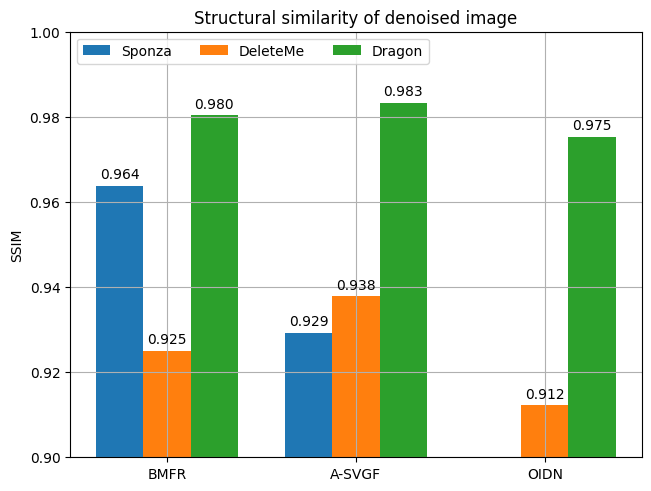

In [14]:
species = ("BMFR", "A-SVGF", "OIDN")
penguin_means = {
    'Sponza': [score_sponza_ssim_bmfr, score_sponza_ssim_asvgf, score_sponza_ssim_oidn],
    'DeleteMe': [score_deleteme_ssim_bmfr, score_deleteme_ssim_asvgf, score_deleteme_ssim_oidn],
    'Dragon': [score_dragon_ssim_bmfr, score_dragon_ssim_asvgf, score_dragon_ssim_oidn],
}

x = np.arange(len(species))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.3f')
    multiplier += 1
    
ax.grid(True)
ax.set_ylabel('SSIM')
ax.set_title('Structural similarity of denoised image')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0.9, 1.0)


# plt.grid(True)
plt.show()

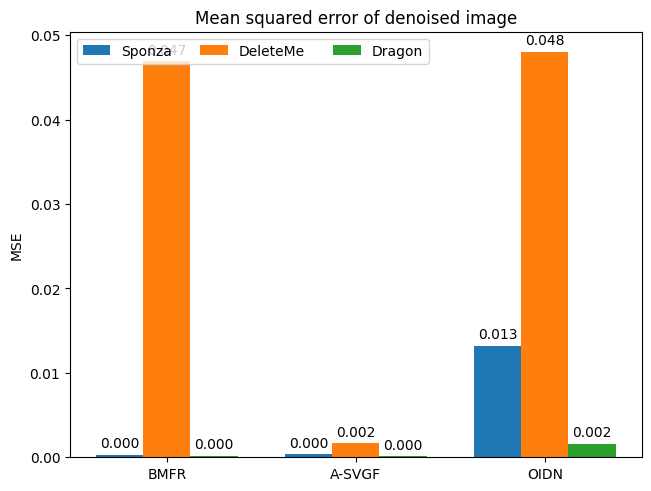

In [15]:
species = ("BMFR", "A-SVGF", "OIDN")
penguin_means = {
    'Sponza': [score_sponza_mse_bmfr, score_sponza_mse_asvgf, score_sponza_mse_oidn],
    'DeleteMe': [score_deleteme_mse_bmfr, score_deleteme_mse_asvgf, score_deleteme_mse_oidn],
    'Dragon': [score_dragon_mse_bmfr, score_dragon_mse_asvgf, score_dragon_mse_oidn],
}

x = np.arange(len(species))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt='%.3f')
    multiplier += 1

ax.set_ylabel('MSE')
ax.set_title('Mean squared error of denoised image')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0.9, 1.0)

plt.show()

In [17]:
oidn_benchmark = open("build/oidn_benchmark.csv", "r").readlines()
asvgf_benchmark = open("build/a-svgf_benchmark.csv", "r").readlines()
bmfr_benchmark = open("build/bmfr_benchmark.csv", "r").readlines()

# Computing average computing time of OIDN
oidn_average = 0.0
oidn_number = 0.0

for entry in oidn_benchmark:
    oidn_average += float(entry)
    oidn_number += 1

oidn_average /= oidn_number

print("Method A:", oidn_average)

# Computing average computing time of A-SVGF
asvgf_average = 0.0
asvgf_number = 0.0

for entry in asvgf_benchmark:
    asvgf_average += float(entry)
    asvgf_number += 1

asvgf_average /= asvgf_number

print("Method B:", asvgf_average)

# Computing average computing time of BMFR
bmfr_average = 0.0
bmfr_number = 0.0

for entry in bmfr_benchmark:
    bmfr_average += float(entry)
    bmfr_number += 1

bmfr_average /= bmfr_number

print("Method C:", bmfr_average)


Method A: 706.4021739130435
Method B: 5.4576271186440675
Method C: 8.585227272727273


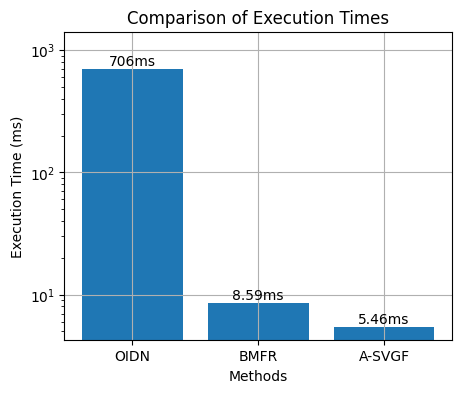

In [28]:
methods = ['OIDN', 'BMFR', 'A-SVGF']
execution_times = [oidn_average, bmfr_average, asvgf_average]

plt.figure(figsize=(5, 4))
plt.bar(methods, execution_times)
plt.xlabel('Methods')
plt.ylabel('Execution Time (ms)')
plt.yscale('log')
plt.grid(True)
for i, v in enumerate(execution_times):
    plt.text(i, v, f'{v:.3g}ms', ha='center', va='bottom')
plt.title('Comparison of Execution Times')
plt.ylim(top=max(execution_times) * 2.0)

plt.show()